In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def borehole_plots(df, parameter, c):
    borehole_list = df["PointID"].unique()
    bh = 0
    fig, axes = plt.subplots(3, 4)
    fig.suptitle(f'Distribution of {parameter} by geological layers', size=30, x=0.5, y=0.92)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    sns.set(rc={"figure.figsize":(20, 27)})
    sns.set(font_scale=1) 
    for row in range(3):
        for col in range(4):
            if bh >= len(borehole_list):
                pass
            else:
                filtered_df = df[df["PointID"] == borehole_list[bh]]
                ax = sns.stripplot(data=filtered_df, x=parameter, y="Index", ax=axes[row, col], orient="h", color=c, 
                                   jitter=False, s=10, marker="D", linewidth=1, alpha=.1)
                ax = sns.boxplot(data=filtered_df, x=parameter, y="Index", ax=axes[row, col], orient="h", boxprops=dict(alpha=.7), linewidth=1, showfliers= False)
                ax.set_title(borehole_list[bh], size=16)
                ax.set_ylabel("Layers")
                bh += 1

## Import Su from raw gINT data

In [8]:
sample, depth, su, test = [], [], [], []
su_dict = {
    "LPEN" : "LPEN_PPEN",
    "TORV":"TORV_PUSS",
    "UU":"TRIT_CU",
    "CU":"TRET_SHST",
    "DSS":"DSST_FSHS"}

for test_type in su_dict:
    df = pd.read_excel("data/gint export_310724_su.xlsx", test_type)
    if test_type == "CU":
        cu_test_type = df["Test type"].to_list()
    # Add id, su and tests into respective lists
    for i in range(len(df)):
        sample.append(df["PointID"][i])
        depth.append(df["Depth"][i])
        su.append(abs(df[su_dict[test_type]][i]))    # use abs here because some Su from CAUe are negative
        if test_type == "CU":
            test.append(df["Test type"][i])
        elif test_type == "UU" or test_type == "DSS":
            test.append(test_type)
        else:
            pass

In [10]:
cpt_df = pd.read_excel("data/CPT parameter.xlsx")
su_df = pd.DataFrame(list(zip(sample, depth, su, test)), columns=["PointID", "Depth", "Su", "Test"])
geo_df = pd.read_excel("data/BD profile.xlsx")
su_df

PointID  Depth   Su Test
0    544WTG23-BH01   9.89  150   UU
1    544WTG23-BH01   9.90  150   UU
2    544WTG23-BH01  10.30  100   UU
3    544WTG23-BH01  10.31  100   UU
4    544WTG23-BH01  10.50  100   UU
..             ...    ...  ...  ...
120  544WTG23-BH02  26.10  350  DSS
121  544WTG23-BH02  26.30  350  DSS
122  544WTG23-BH02  26.50  300  DSS
123  544WTG23-BH02  27.20  400  DSS
124  544WTG23-BH02  27.40  350  DSS

[125 rows x 4 columns]

# Calculate Su for different Nkt values

In [12]:
cpt_df["Su (Nkt 10)"] = (cpt_df["qnet (kPa)"] - cpt_df["σv (kPa)"]) / 10
cpt_df["Su (Nkt 20)"] =  (cpt_df["qnet (kPa)"] - cpt_df["σv (kPa)"]) / 20

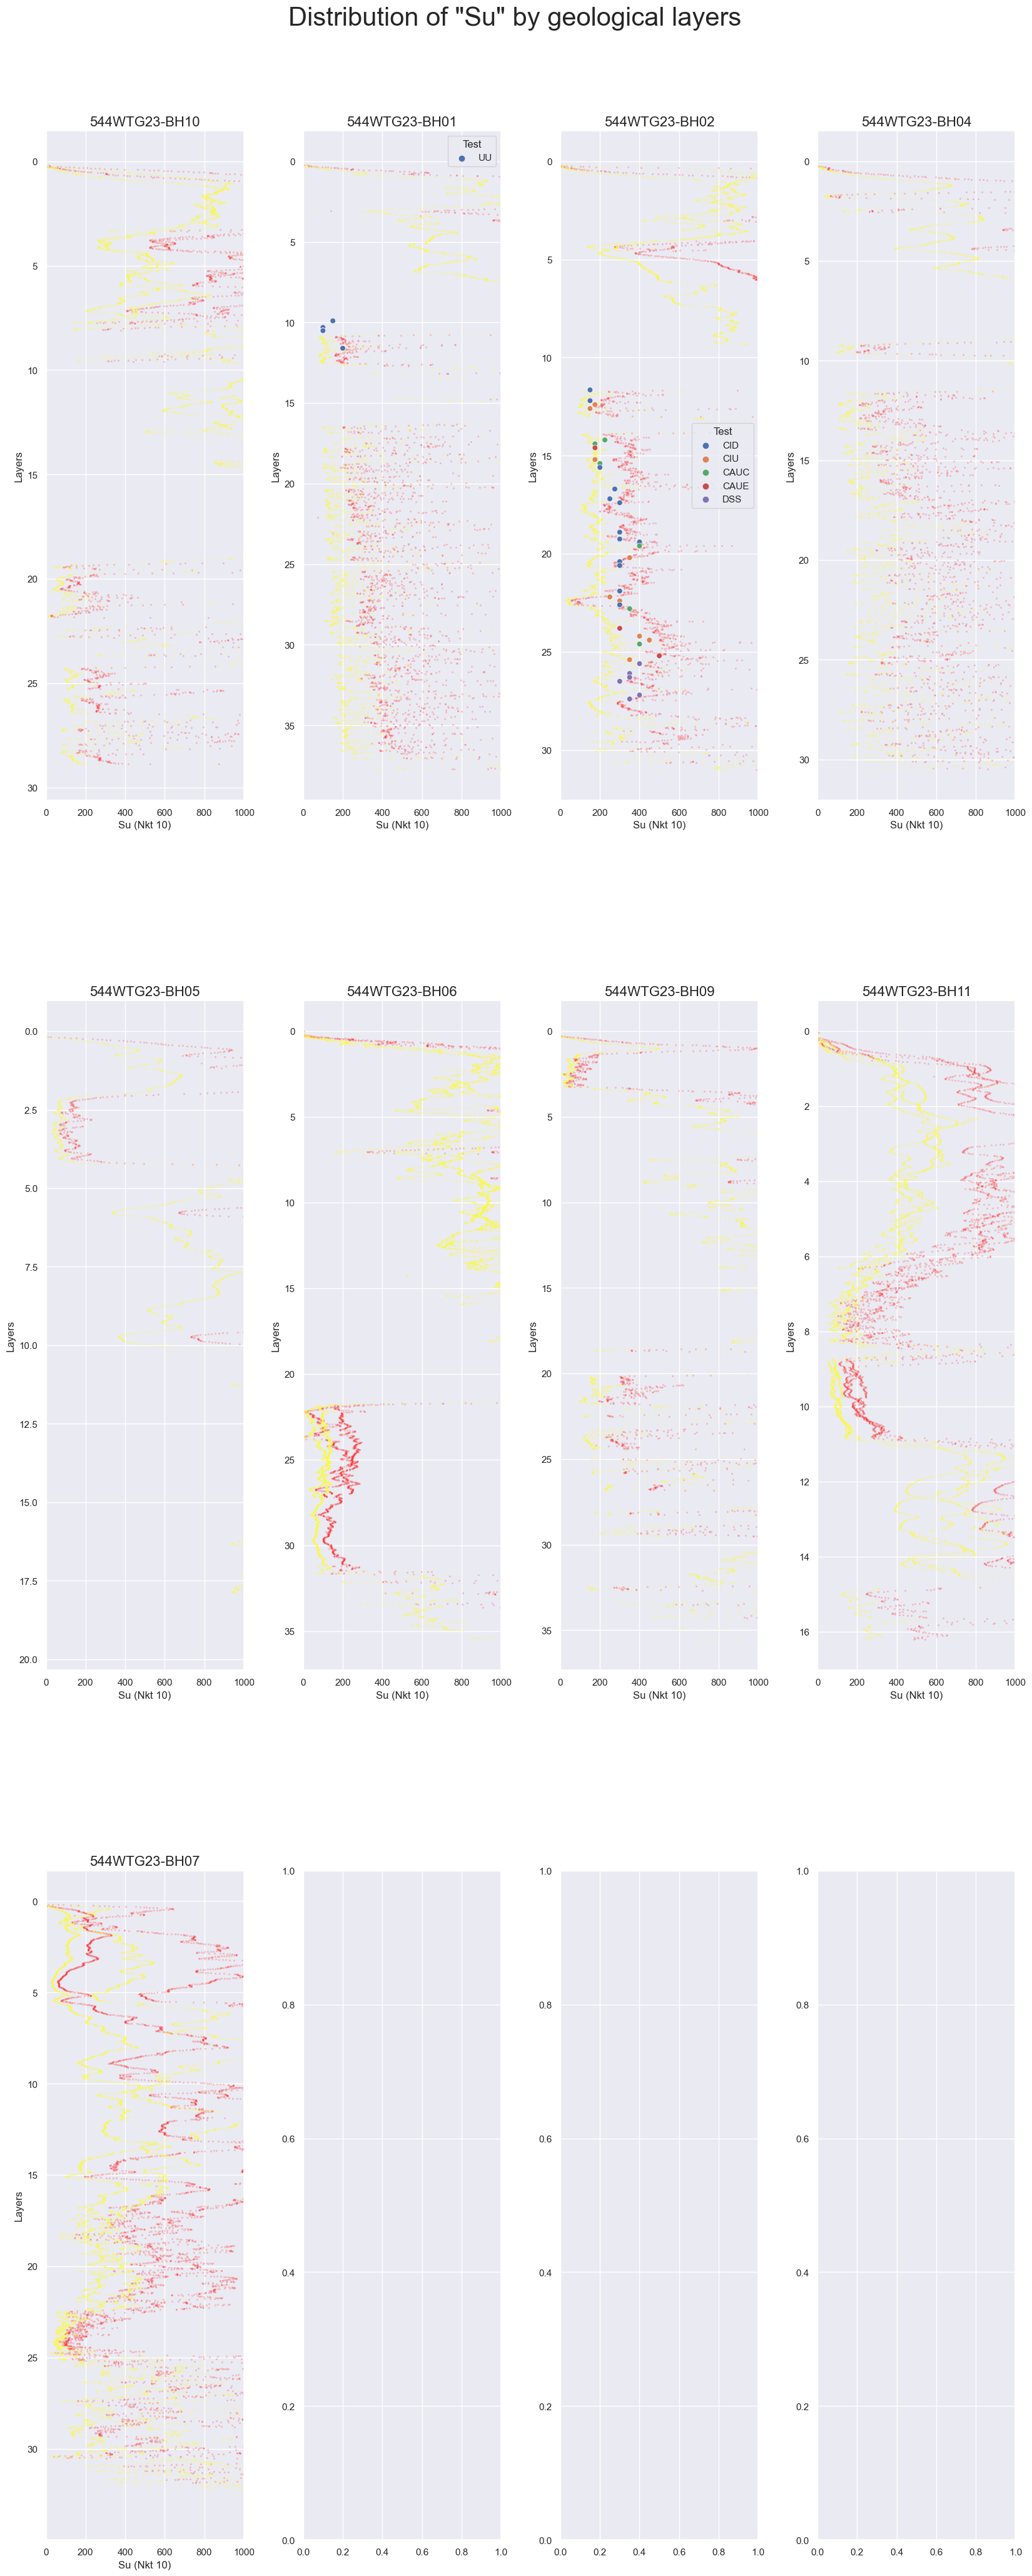

In [16]:
plot_df = cpt_df
borehole_list = plot_df["PointID"].unique()
bh = 0
fig, axes = plt.subplots(3, 4)
fig.suptitle(f'Distribution of "Su" by geological layers', size=30, x=0.5, y=0.92)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
sns.set(rc={"figure.figsize":(20, 50)})
sns.set(font_scale=1) 
for row in range(3):
    for col in range(4):
        if bh >= len(borehole_list):
            pass
        else:
            filtered_df = plot_df[plot_df["PointID"] == borehole_list[bh]]
            fsu_df = su_df[su_df["PointID"] == borehole_list[bh]]
            ax = sns.scatterplot(data=filtered_df, x="Su (Nkt 10)", y="Depth (m)", alpha=0.2, ax=axes[row, col], s=5, color="red")
            ax = sns.scatterplot(data=filtered_df, x="Su (Nkt 20)", y="Depth (m)", alpha=0.2, ax=axes[row, col], s=5, color="yellow")
            ax = sns.scatterplot(data=fsu_df, x="Su", y="Depth", hue="Test", alpha=1, ax=axes[row, col], s=40)
            ax.set_title(borehole_list[bh], size=16)
            ax.set_ylabel("Layers")
            ax.invert_yaxis()
            ax.set_xlim(0, 1000)
            bh += 1

# Average values to declutter

In [16]:
# Create dictionary with depth for each BH
cpt_depth = {}
for bh in cpt_df["PointID"].unique():
    filtered_df = cpt_df[cpt_df["PointID"] == bh]
    bottom_depth = filtered_df["Depth (m)"].max()
    cpt_depth[bh] = bottom_depth

# Put mean Su data into list
su_mean_data = []
for bh in cpt_df["PointID"].unique():
    depth_list = [i/10 for i in range(0, int(cpt_depth[bh])*10, int(0.1*10))]
    bh_df = cpt_df[cpt_df["PointID"] == bh]
    for z in depth_list:
        unit_df = bh_df[(bh_df["Depth (m)"] <= z + 0.5) & (bh_df["Depth (m)"] >= z - 0.5)]
        mean_su = unit_df[["Su", "Su (Nkt 10)", "Su (Nkt 20)"]].mean().to_list()
        su_mean_data.append([bh, z] + mean_su)

su_mean = pd.DataFrame(su_mean_data, columns=["PointID", "Depth (m)", "Su", "Su (Nkt 10)", "Su (Nkt 20)"])
su_mean

PointID  Depth (m)           Su  Su (Nkt 10)  Su (Nkt 20)
0     544WTG23-BH10        0.0    73.577157   103.008020    51.504010
1     544WTG23-BH10        0.1   125.849653   176.189514    88.094757
2     544WTG23-BH10        0.2   179.586378   251.420929   125.710464
3     544WTG23-BH10        0.3   240.629577   336.881408   168.440704
4     544WTG23-BH10        0.4   304.448202   426.227483   213.113742
...             ...        ...          ...          ...          ...
2645  544WTG23-BH07       32.5  2019.740205  2827.636287  1413.818143
2646  544WTG23-BH07       32.6  2106.795980  2949.514372  1474.757186
2647  544WTG23-BH07       32.7  2162.135949  3026.990329  1513.495164
2648  544WTG23-BH07       32.8  2235.717203  3130.004084  1565.002042
2649  544WTG23-BH07       32.9  2288.679339  3204.151074  1602.075537

[2650 rows x 5 columns]

## Plot with all cpt data

ValueError: The palette dictionary is missing keys: {'CID'}

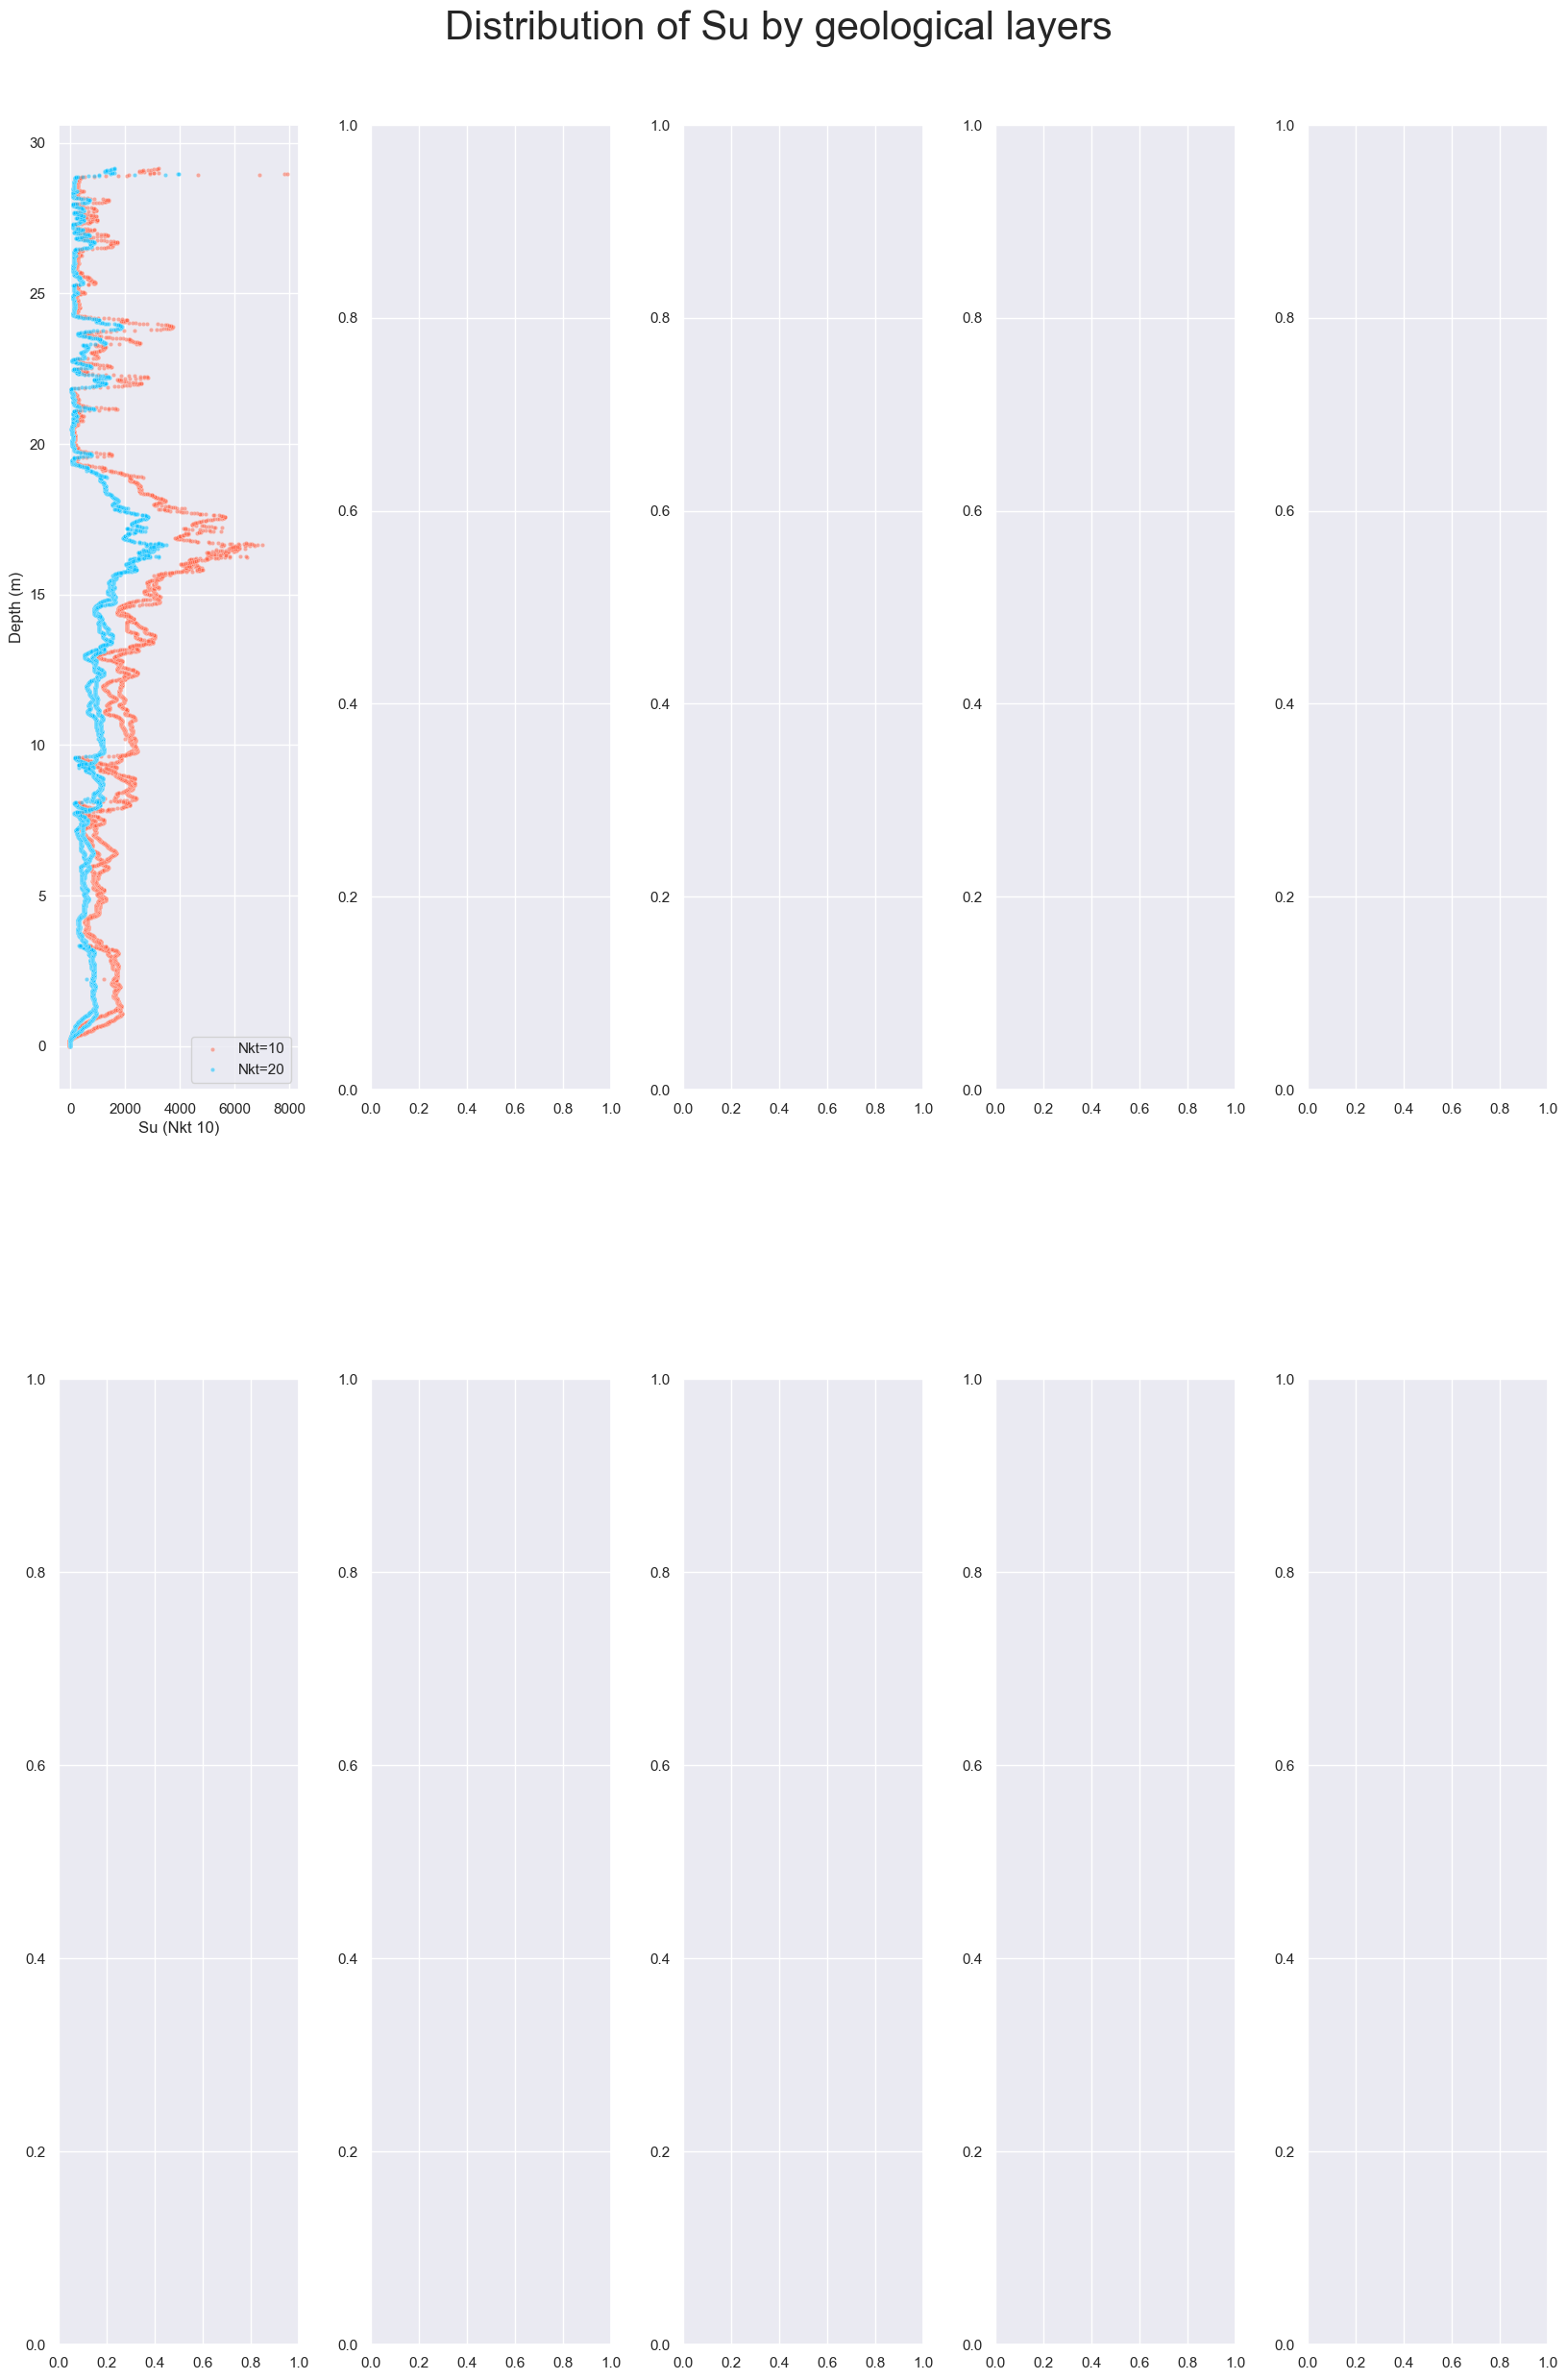

In [19]:
plot_df = cpt_df
xmin, xmax = 0, 1000
############################
borehole_list = plot_df["PointID"].unique()
bh = 0
fig, axes = plt.subplots(2, 5)
fig.suptitle(f'Distribution of Su by geological layers', size=30, x=0.5, y=0.92)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
sns.set(rc={"figure.figsize":(20, 30)})
sns.set(font_scale=1) 
for row in range(2):
    for col in range(5):
        if bh >= len(borehole_list):
            pass
        else:
            filtered_df = plot_df[plot_df["PointID"] == borehole_list[bh]]
            fsu_df = su_df[su_df["PointID"] == borehole_list[bh]]
            ax = sns.scatterplot(data=filtered_df, x="Su (Nkt 10)", y="Depth (m)", alpha=0.5, ax=axes[row, col], color="tomato", s=10, label="Nkt=10")
            ax = sns.scatterplot(data=filtered_df, x="Su (Nkt 20)", y="Depth (m)", alpha=0.5, ax=axes[row, col], color="deepskyblue", s=10, label="Nkt=20")
            ax = sns.scatterplot(data=fsu_df, x="Su", y="Depth", hue="Test", marker="X", alpha=1, ax=axes[row, col], s=80,
                                 palette=dict(CU="#9b59b6", UU="#076928", LPEN="#eb4034", TORV="#a69b08"))
            # Plot geology
            bh_geo = geo_df[geo_df["PointID"] == borehole_list[bh]]
            for z, geol in zip(bh_geo["Depth"].to_list(), bh_geo["Soil type"].to_list()):
                if geol == "01-CLAY" or geol == "02-SILT":
                    ax = sns.lineplot(x=[xmin, xmax], y=[z, z], ax=axes[row, col], alpha=1, color="firebrick", linestyle='dashed')
                else:
                    ax = sns.lineplot(x=[xmin, xmax], y=[z, z], ax=axes[row, col], alpha=0.3, color="navy", linestyle='dashed')
            ax.set_title(borehole_list[bh], size=16)
            ax.set_ylabel("Depth (m)")
            ax.set_xlabel("Su (kPa)")
            ax.invert_yaxis()
            ax.set_xlim(0, 1000)
            ax.legend()
            bh += 1

## Plot with reduced data points

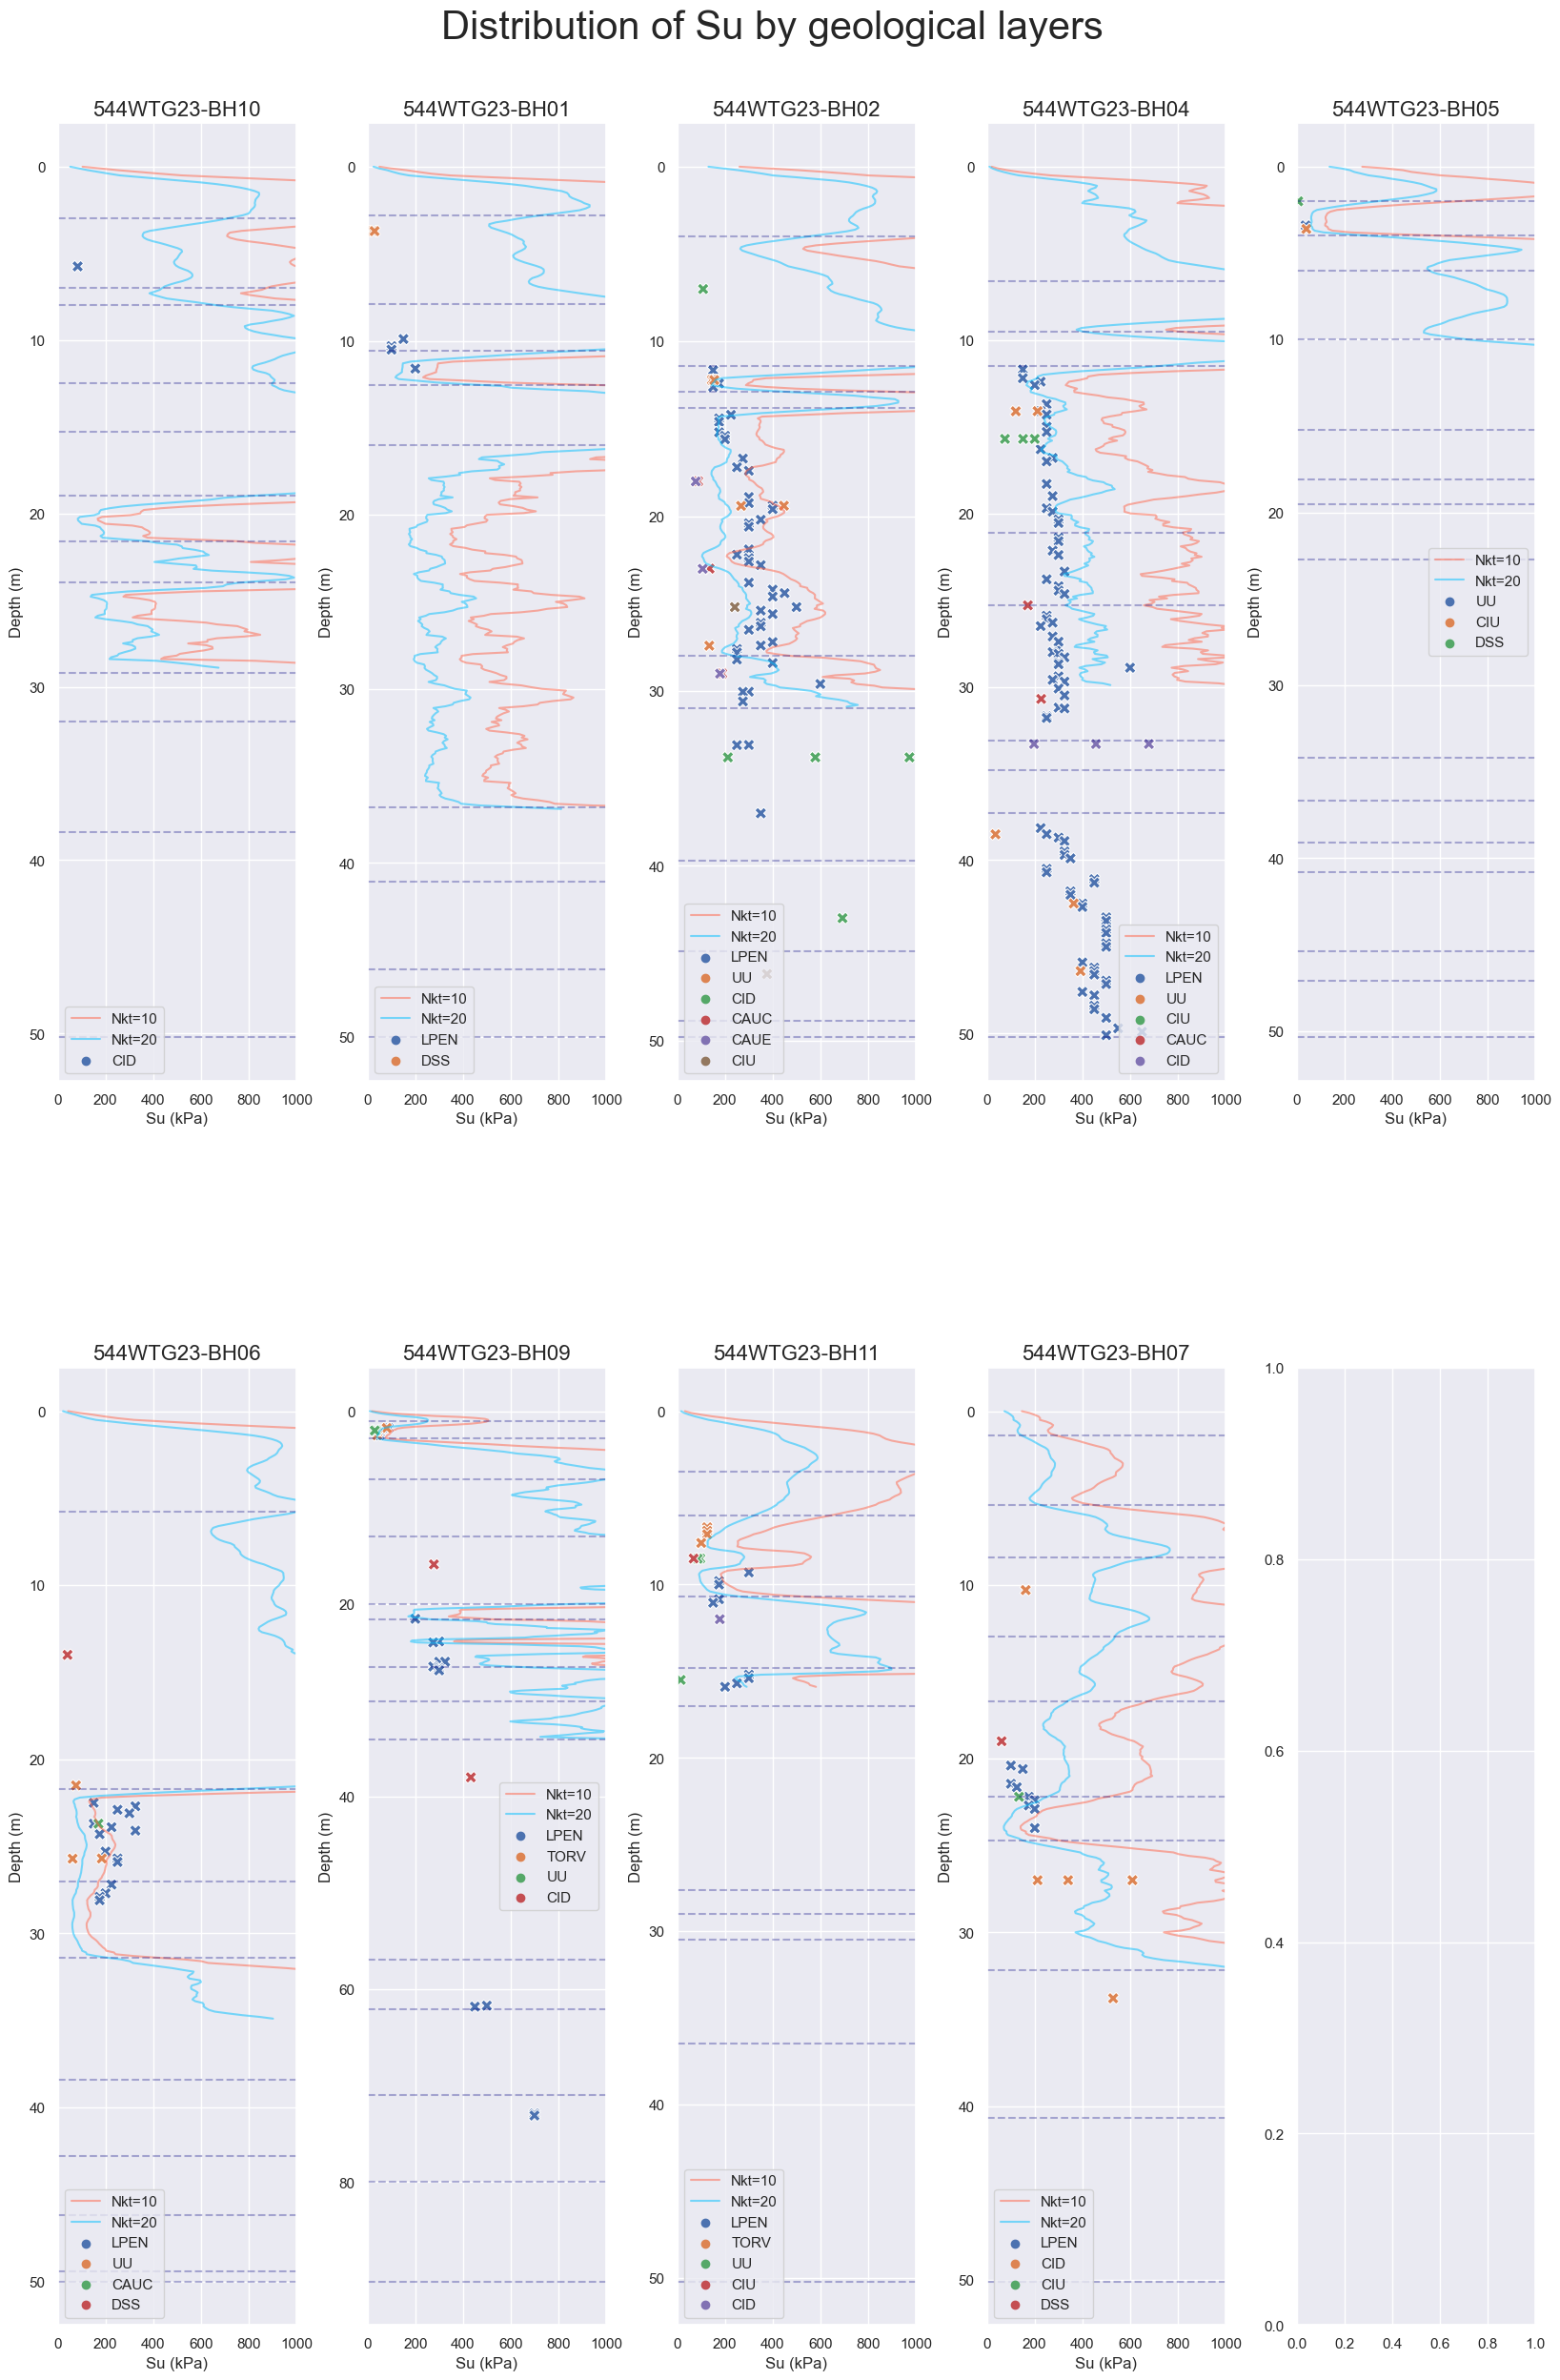

In [20]:
plot_df = su_mean
xmin, xmax = 0, 1000
parameter = "Su"
############################
borehole_list = plot_df["PointID"].unique()
bh = 0
fig, axes = plt.subplots(2, 5)
fig.suptitle(f'Distribution of {parameter} by geological layers', size=30, x=0.5, y=0.92)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
sns.set(rc={"figure.figsize":(20, 30)})
sns.set(font_scale=1) 
for row in range(2):
    for col in range(5):
        if bh >= len(borehole_list):
            pass
        else:
            filtered_df = plot_df[plot_df["PointID"] == borehole_list[bh]]
            fsu_df = su_df[su_df["PointID"] == borehole_list[bh]]
            ax = sns.lineplot(data=filtered_df, x="Su (Nkt 10)", y="Depth (m)", alpha=0.5, ax=axes[row, col], color="tomato", orient="y", label="Nkt=10")
            ax = sns.lineplot(data=filtered_df, x="Su (Nkt 20)", y="Depth (m)", alpha=0.5, ax=axes[row, col], color="deepskyblue", orient="y", label="Nkt=20")
            ax = sns.scatterplot(data=fsu_df, x=parameter, y="Depth", hue="Test", marker="X", alpha=1, ax=axes[row, col], s=80)
            #ax = sns.scatterplot(data=fsu_df, x=parameter, y="Depth", hue="Test", marker="X", alpha=1, ax=axes[row, col], s=80,
               #                  palette=dict(CU="#9b59b6", UU="#076928", LPEN="#eb4034", TORV="#a69b08"))
            # Plot geology
            bh_geo = geo_df[geo_df["PointID"] == borehole_list[bh]]
            for z in bh_geo["Depth"].to_list():
                    ax = sns.lineplot(x=[xmin, xmax], y=[z, z], ax=axes[row, col], alpha=0.3, color="navy", linestyle='dashed')
            ax.set_title(borehole_list[bh], size=16)
            ax.set_ylabel("Depth (m)")
            ax.set_xlabel("Su (kPa)")
            ax.invert_yaxis()
            ax.set_xlim(0, 1000)
            ax.legend()
            bh += 1

## Derive Nkt

In [21]:
def find_Nkt(cpt_df, bh, depth, cpt_su):
    df = cpt_df[cpt_df["PointID"] == bh]
    df = df[(df["Depth (m)"] < depth + 0.1) & (df["Depth (m)"] > depth - 0.1)]
    Nkt = (df["qnet (kPa)"].mean() - df["σv (kPa)"].mean()) / cpt_su 
    return Nkt

In [22]:
su_df["Derived Nkt"] = su_df.apply(lambda x: find_Nkt(cpt_df, x.PointID, x.Depth, x.Su), axis=1, result_type="expand")
# su_df["Nkt check"] = su_df["Derived Nkt"].apply(lambda x: "In" if (x <= 20 and x > 10) else ("Mid" if (x < 25 and x > 10) else "Out"))
su_df["Nkt check"] = su_df["Derived Nkt"].apply(lambda x: "In" if (x <= 20 and x > 10) else "Out")
su_df

PointID  Depth     Su  Test  Derived Nkt Nkt check
0     544WTG23-BH01   9.89  150.0  LPEN   273.468222       Out
1     544WTG23-BH01   9.90  150.0  LPEN   267.578932       Out
2     544WTG23-BH01  10.30  100.0  LPEN   263.203577       Out
3     544WTG23-BH01  10.31  100.0  LPEN   263.327399       Out
4     544WTG23-BH01  10.50  100.0  LPEN   261.939478       Out
..              ...    ...    ...   ...          ...       ...
603   544WTG23-BH01   3.70   29.0   DSS   365.172155       Out
604  544WTG23-BH03a  18.50   32.0   DSS          NaN       Out
605   544WTG23-BH05   2.00    6.0   DSS  1085.113184       Out
606   544WTG23-BH06  14.00   40.0   DSS   525.556086       Out
607   544WTG23-BH07  19.00   61.0   DSS   113.328957       Out

[608 rows x 6 columns]

<Axes: xlabel='Derived Nkt', ylabel='Test'>

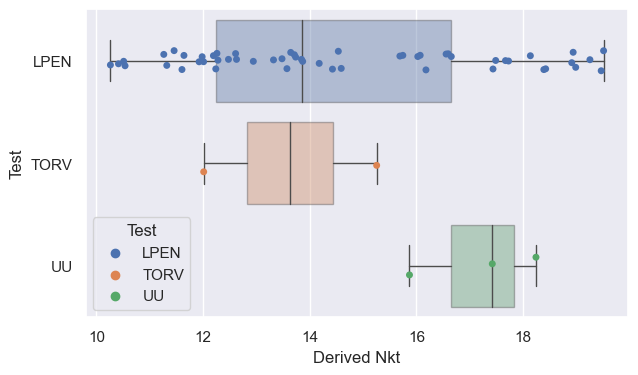

In [23]:
plot_df = su_df[su_df["Nkt check"] == "In"]
sns.set(rc={"figure.figsize":(7, 4)})
sns.boxplot(data=plot_df, x="Derived Nkt", y="Test", boxprops=dict(alpha=.4), linewidth=1, showfliers= False)
sns.stripplot(data=plot_df, x="Derived Nkt", y="Test", orient="h", hue="Test")

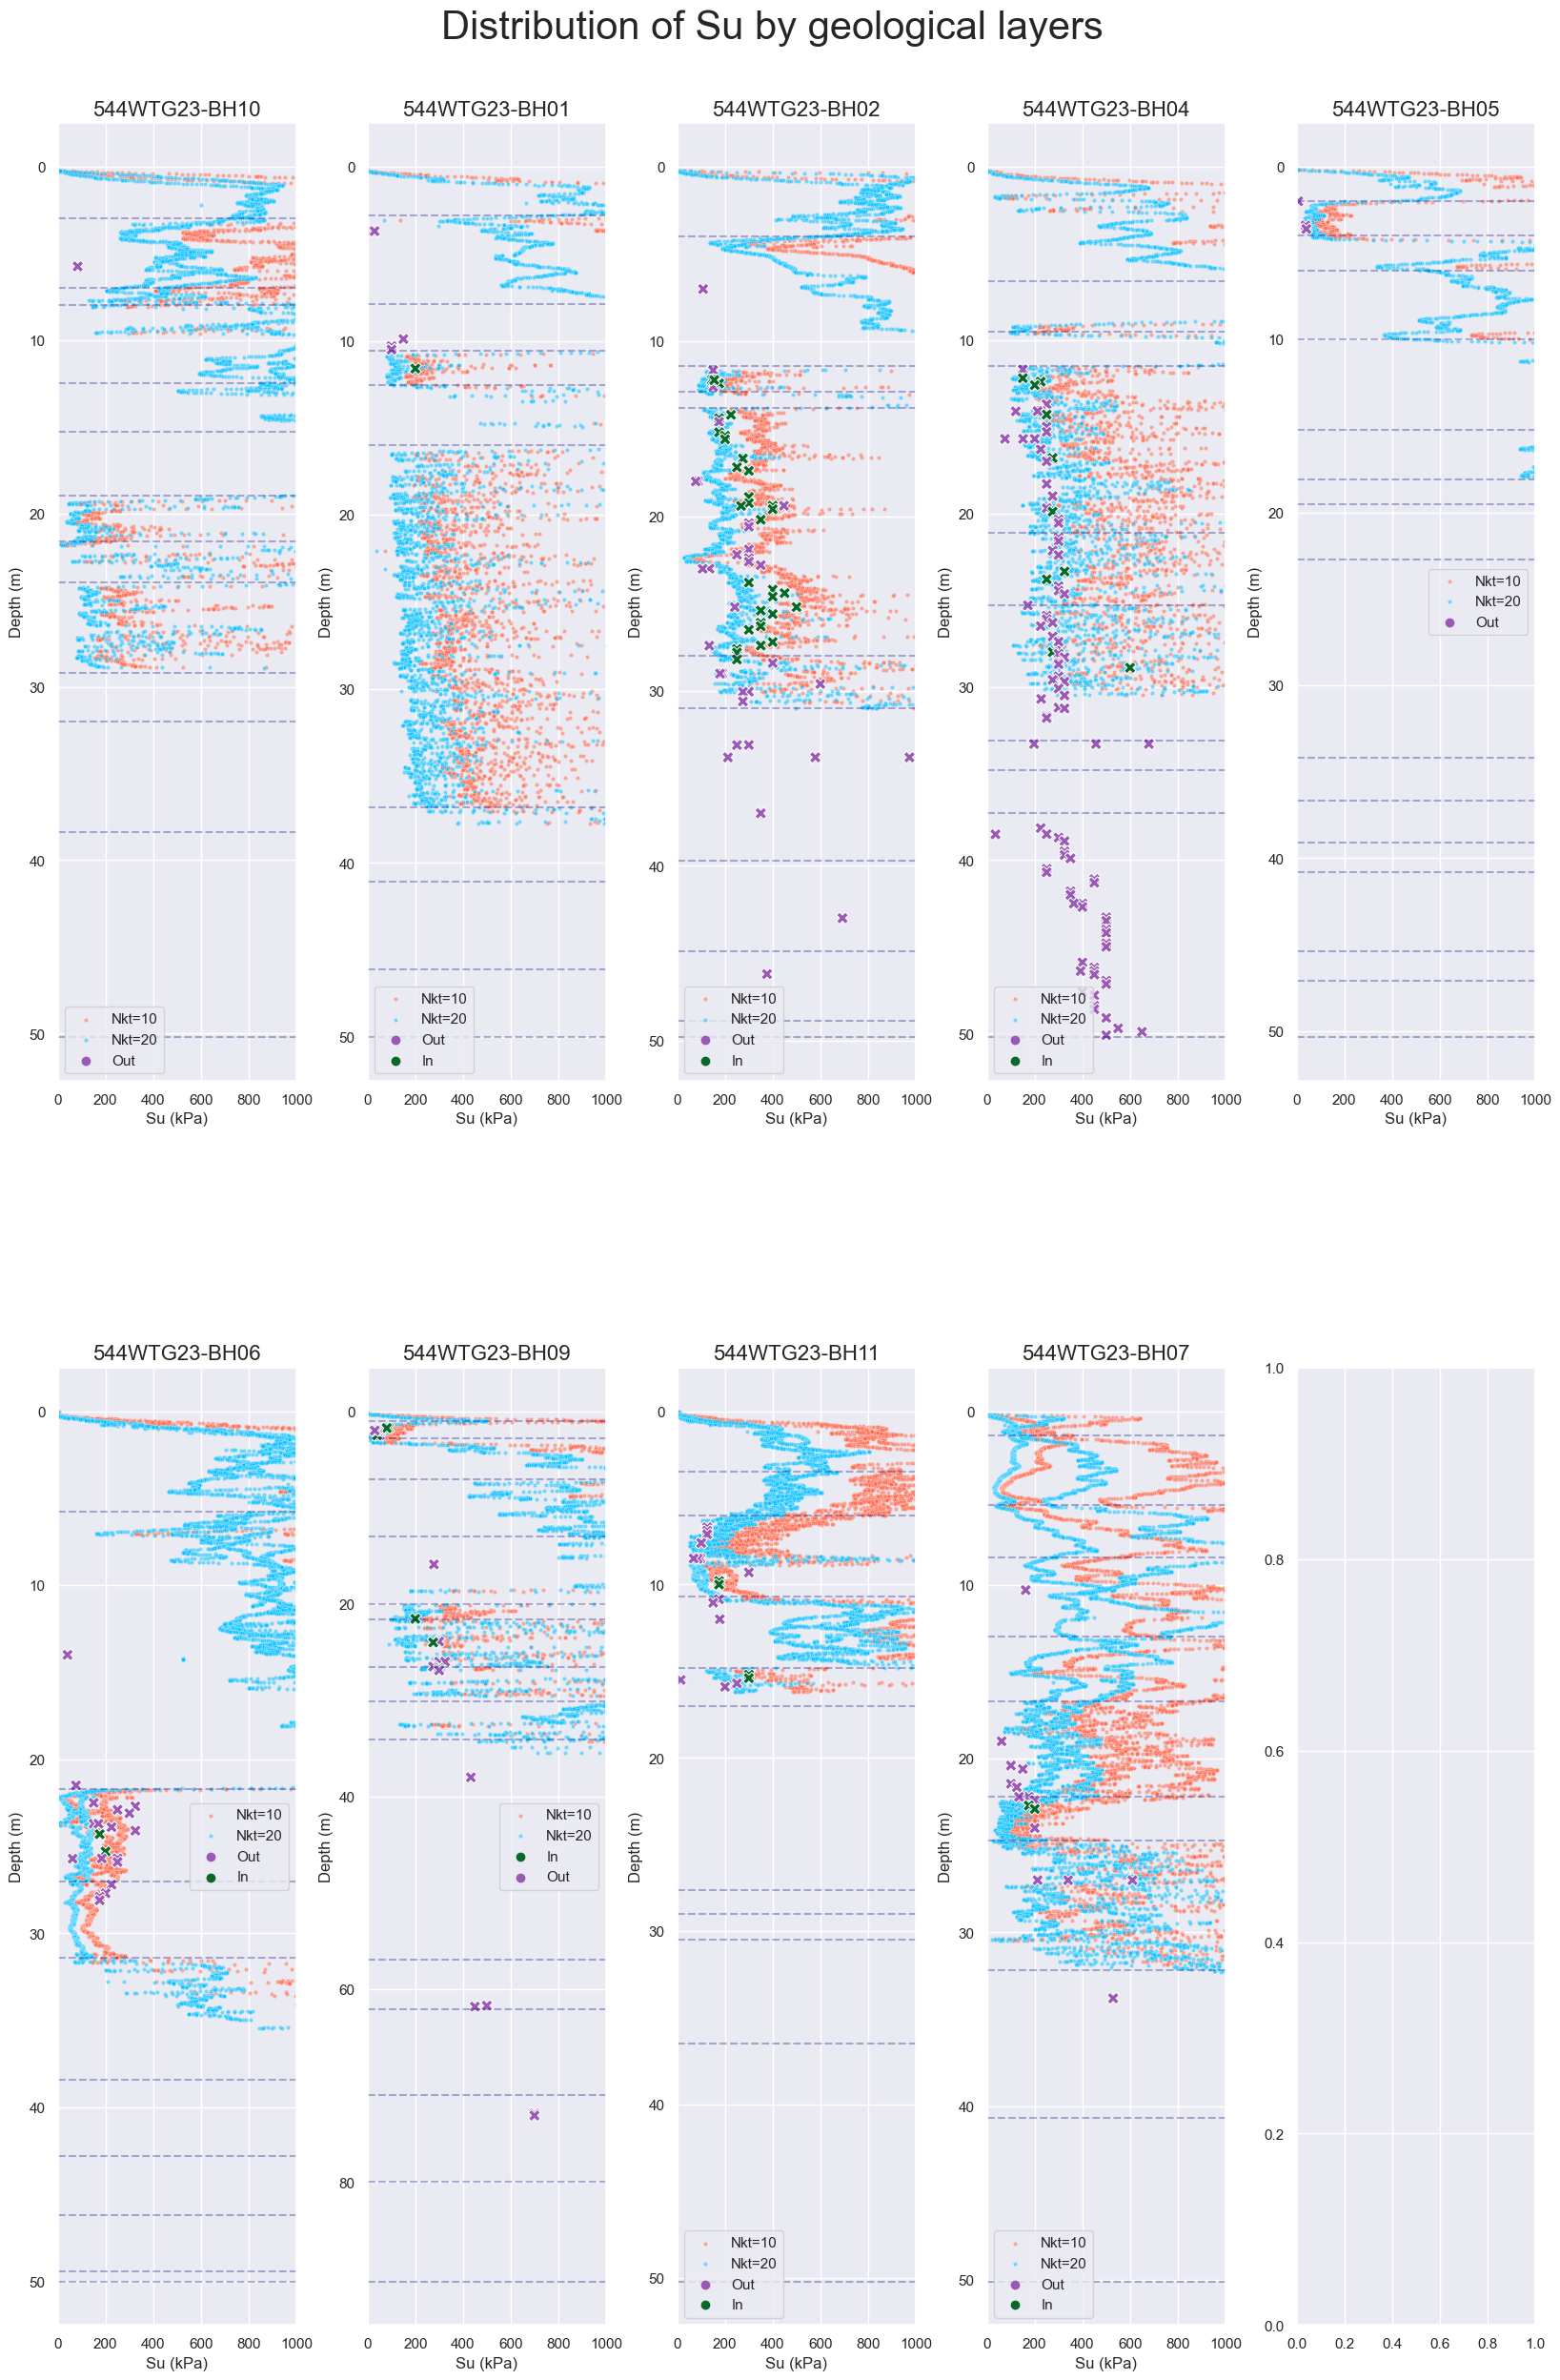

In [22]:
plot_df = cpt_df
xmin, xmax = 0, 1000
############################
borehole_list = plot_df["PointID"].unique()
bh = 0
fig, axes = plt.subplots(2, 5)
fig.suptitle(f'Distribution of {parameter} by geological layers', size=30, x=0.5, y=0.92)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
sns.set(rc={"figure.figsize":(20, 30)})
sns.set(font_scale=1) 
for row in range(2):
    for col in range(5):
        if bh >= len(borehole_list):
            pass
        else:
            filtered_df = plot_df[plot_df["PointID"] == borehole_list[bh]]
            fsu_df = su_df[su_df["PointID"] == borehole_list[bh]]
            ax = sns.scatterplot(data=filtered_df, x="Su (Nkt 10)", y="Depth (m)", alpha=0.5, ax=axes[row, col], color="tomato", s=10, label="Nkt=10")
            ax = sns.scatterplot(data=filtered_df, x="Su (Nkt 20)", y="Depth (m)", alpha=0.5, ax=axes[row, col], color="deepskyblue", s=10, label="Nkt=20")
            ax = sns.scatterplot(data=fsu_df, x=parameter, y="Depth", hue="Nkt check", marker="X", alpha=1, ax=axes[row, col], s=80,
                                palette=dict(Out="#9b59b6", In="#076928", Mid="#f20000"))
            # Plot geology
            bh_geo = geo_df[geo_df["PointID"] == borehole_list[bh]]
            for z in bh_geo["Depth"].to_list():
                    ax = sns.lineplot(x=[xmin, xmax], y=[z, z], ax=axes[row, col], alpha=0.3, color="navy", linestyle='dashed')
            ax.set_title(borehole_list[bh], size=16)
            ax.set_ylabel("Depth (m)")
            ax.set_xlabel("Su (kPa)")
            ax.invert_yaxis()
            ax.set_xlim(0, 1000)
            ax.legend()
            bh += 1

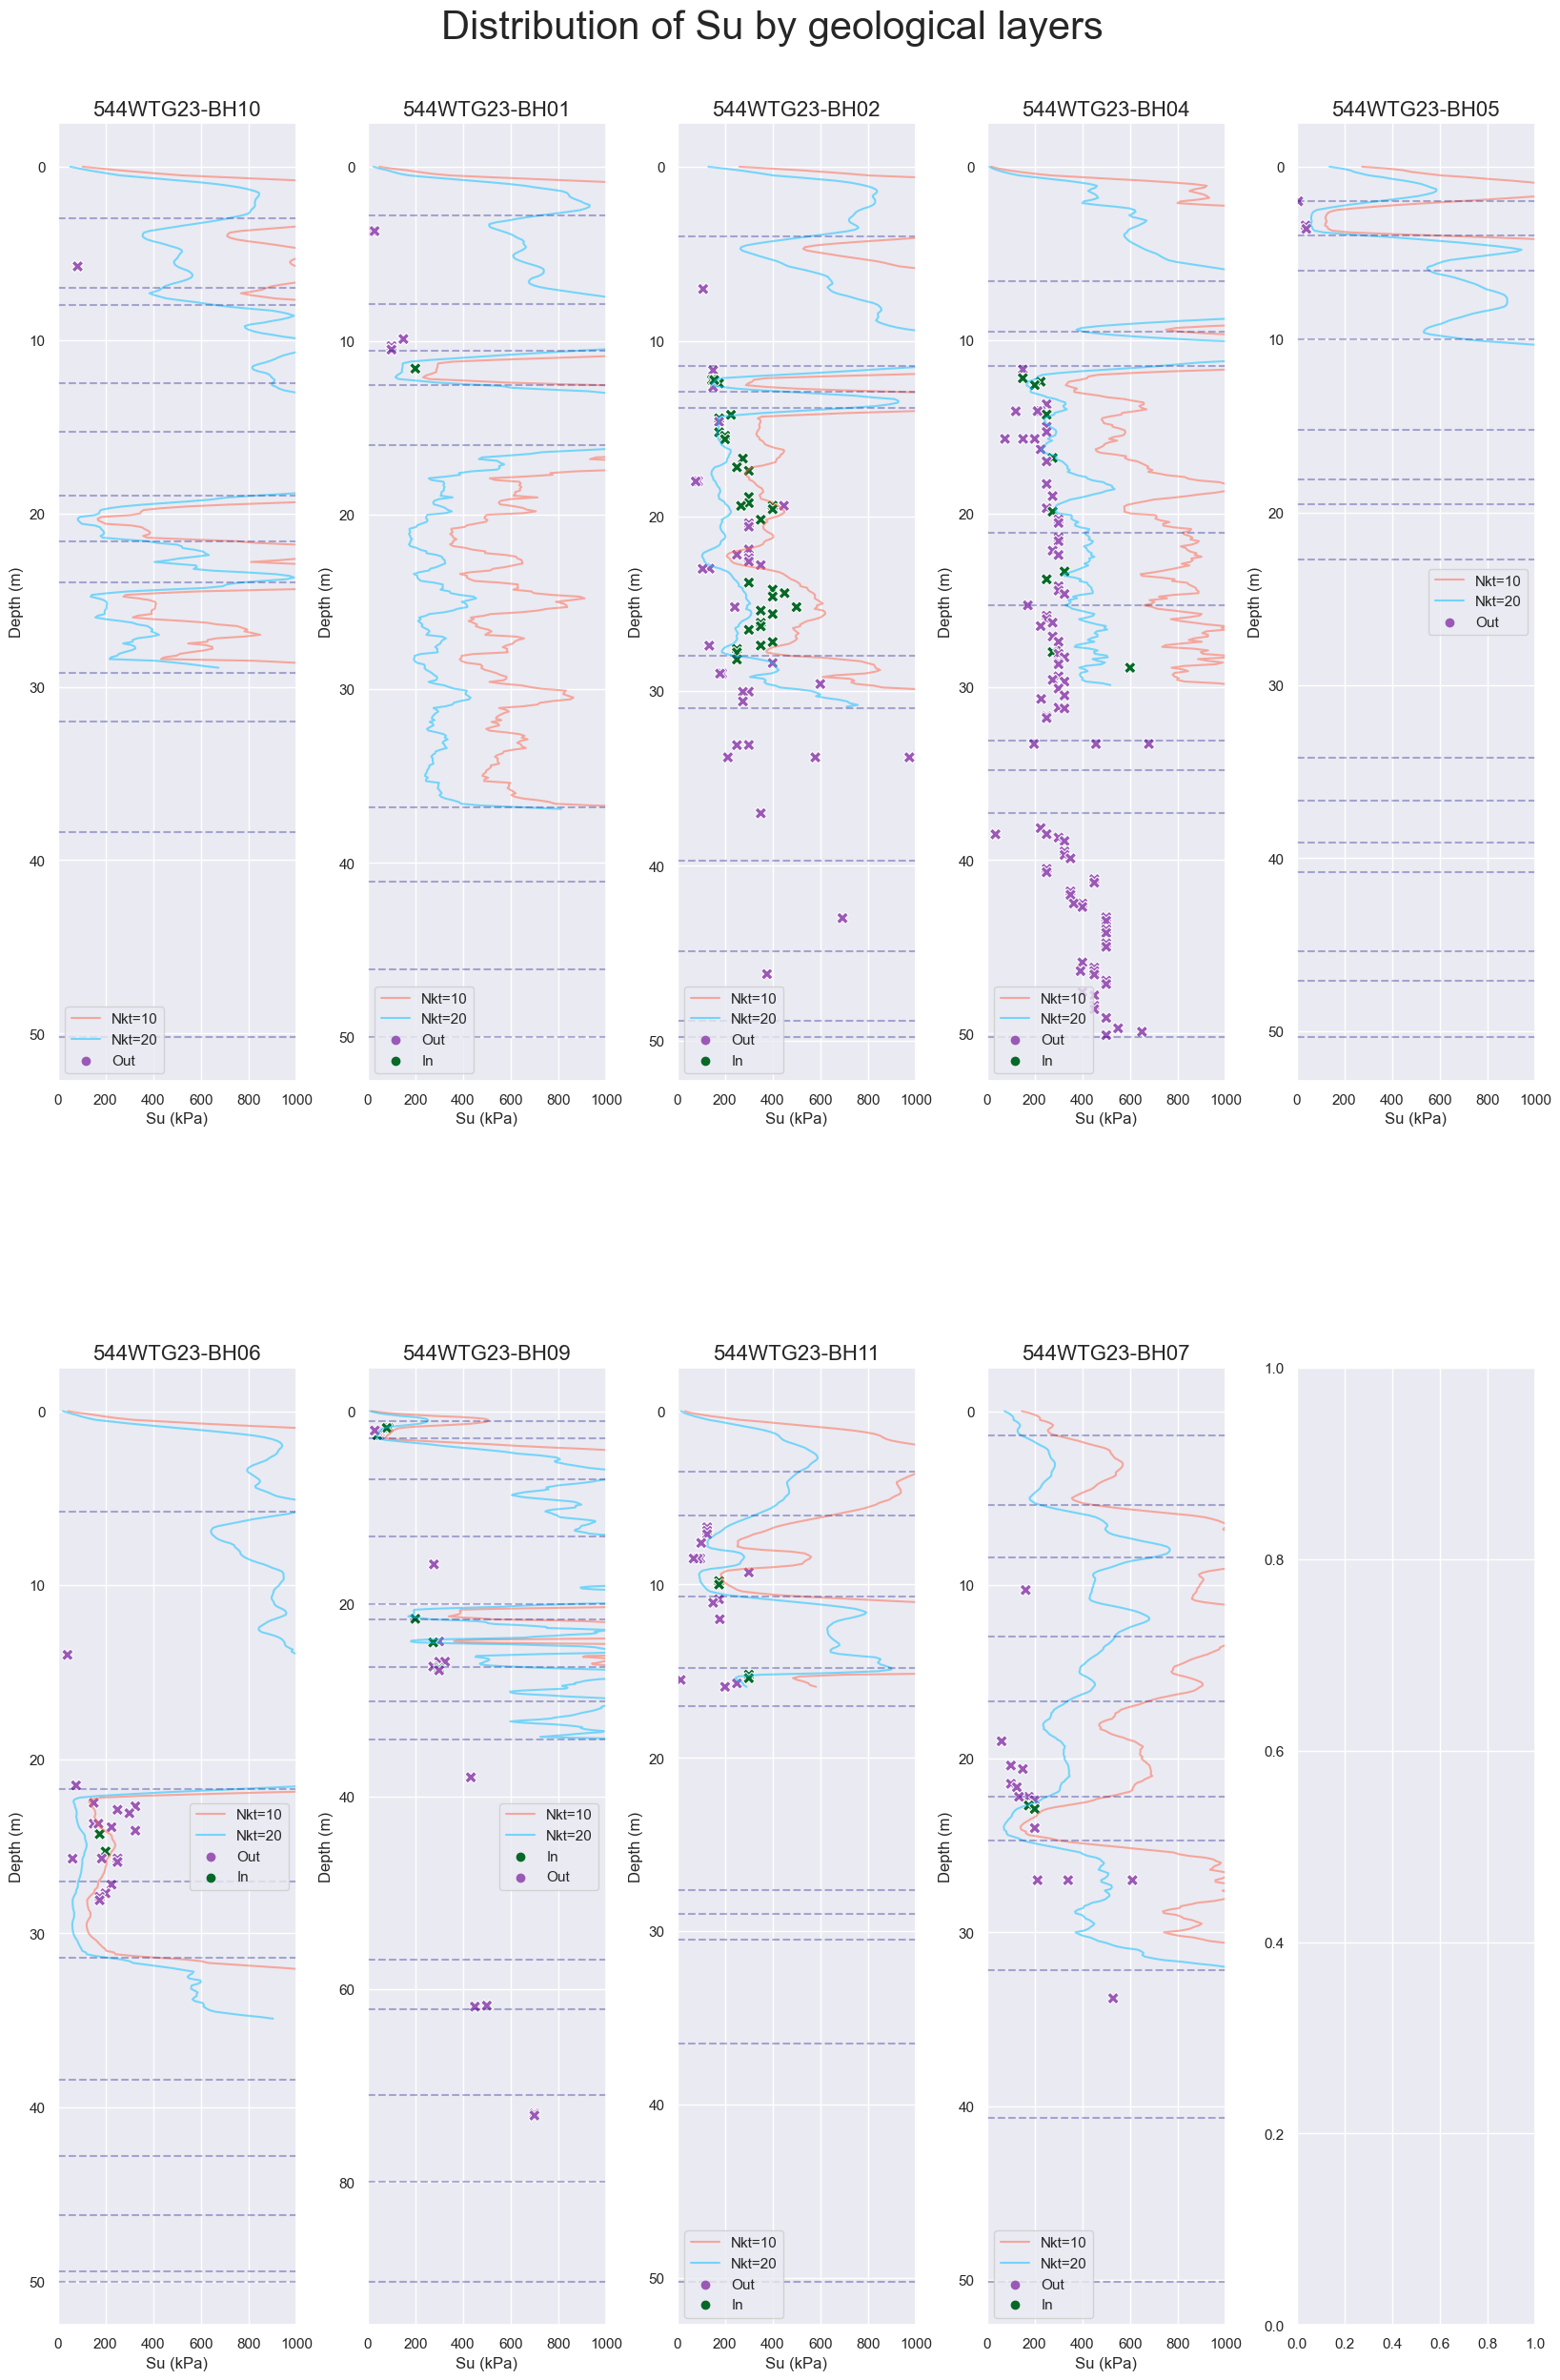

In [23]:
plot_df = su_mean
xmin, xmax = 0, 1000
############################
borehole_list = plot_df["PointID"].unique()
bh = 0
fig, axes = plt.subplots(2, 5)
fig.suptitle(f'Distribution of {parameter} by geological layers', size=30, x=0.5, y=0.92)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
sns.set(rc={"figure.figsize":(20, 30)})
sns.set(font_scale=1) 
for row in range(2):
    for col in range(5):
        if bh >= len(borehole_list):
            pass
        else:
            filtered_df = plot_df[plot_df["PointID"] == borehole_list[bh]]
            fsu_df = su_df[su_df["PointID"] == borehole_list[bh]]
            ax = sns.lineplot(data=filtered_df, x="Su (Nkt 10)", y="Depth (m)", alpha=0.5, ax=axes[row, col], color="tomato", orient="y", label="Nkt=10")
            ax = sns.lineplot(data=filtered_df, x="Su (Nkt 20)", y="Depth (m)", alpha=0.5, ax=axes[row, col], color="deepskyblue", orient="y", label="Nkt=20")
            ax = sns.scatterplot(data=fsu_df, x=parameter, y="Depth", hue="Nkt check", marker="X", alpha=1, ax=axes[row, col], s=80,
                                palette=dict(Out="#9b59b6", In="#076928", Mid="#f20000"))
            # Plot geology
            bh_geo = geo_df[geo_df["PointID"] == borehole_list[bh]]
            for z in bh_geo["Depth"].to_list():
                    ax = sns.lineplot(x=[xmin, xmax], y=[z, z], ax=axes[row, col], alpha=0.3, color="navy", linestyle='dashed')
            ax.set_title(borehole_list[bh], size=16)
            ax.set_ylabel("Depth (m)")
            ax.set_xlabel("Su (kPa)")
            ax.invert_yaxis()
            ax.set_xlim(0, 1000)
            ax.legend()
            bh += 1

## Nkt statistics

Mean = 14.66
Median = 14.02


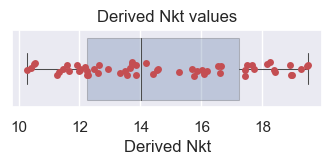

In [26]:
print("Mean =", round(su_df[su_df["Nkt check"] == "In"]["Derived Nkt"].mean(), 2))
print("Median =", round(su_df[su_df["Nkt check"] == "In"]["Derived Nkt"].median(), 2))
under25_df = su_df[su_df["Nkt check"] == "In"]
sns.set(rc={"figure.figsize":(4, 1)})
sns.stripplot(data=under25_df, x="Derived Nkt", c="r")
sns.boxplot(data=under25_df, x="Derived Nkt", boxprops=dict(alpha=.3), linewidth=.75, showfliers= False).set_title("Derived Nkt values")
# Seet value
derived_Nkt = su_df[su_df["Nkt check"] == "In"]["Derived Nkt"].mean()
cpt_df["Su (Nkt derived)"] =  (cpt_df["qnet (kPa)"] - cpt_df["σv (kPa)"]) / derived_Nkt

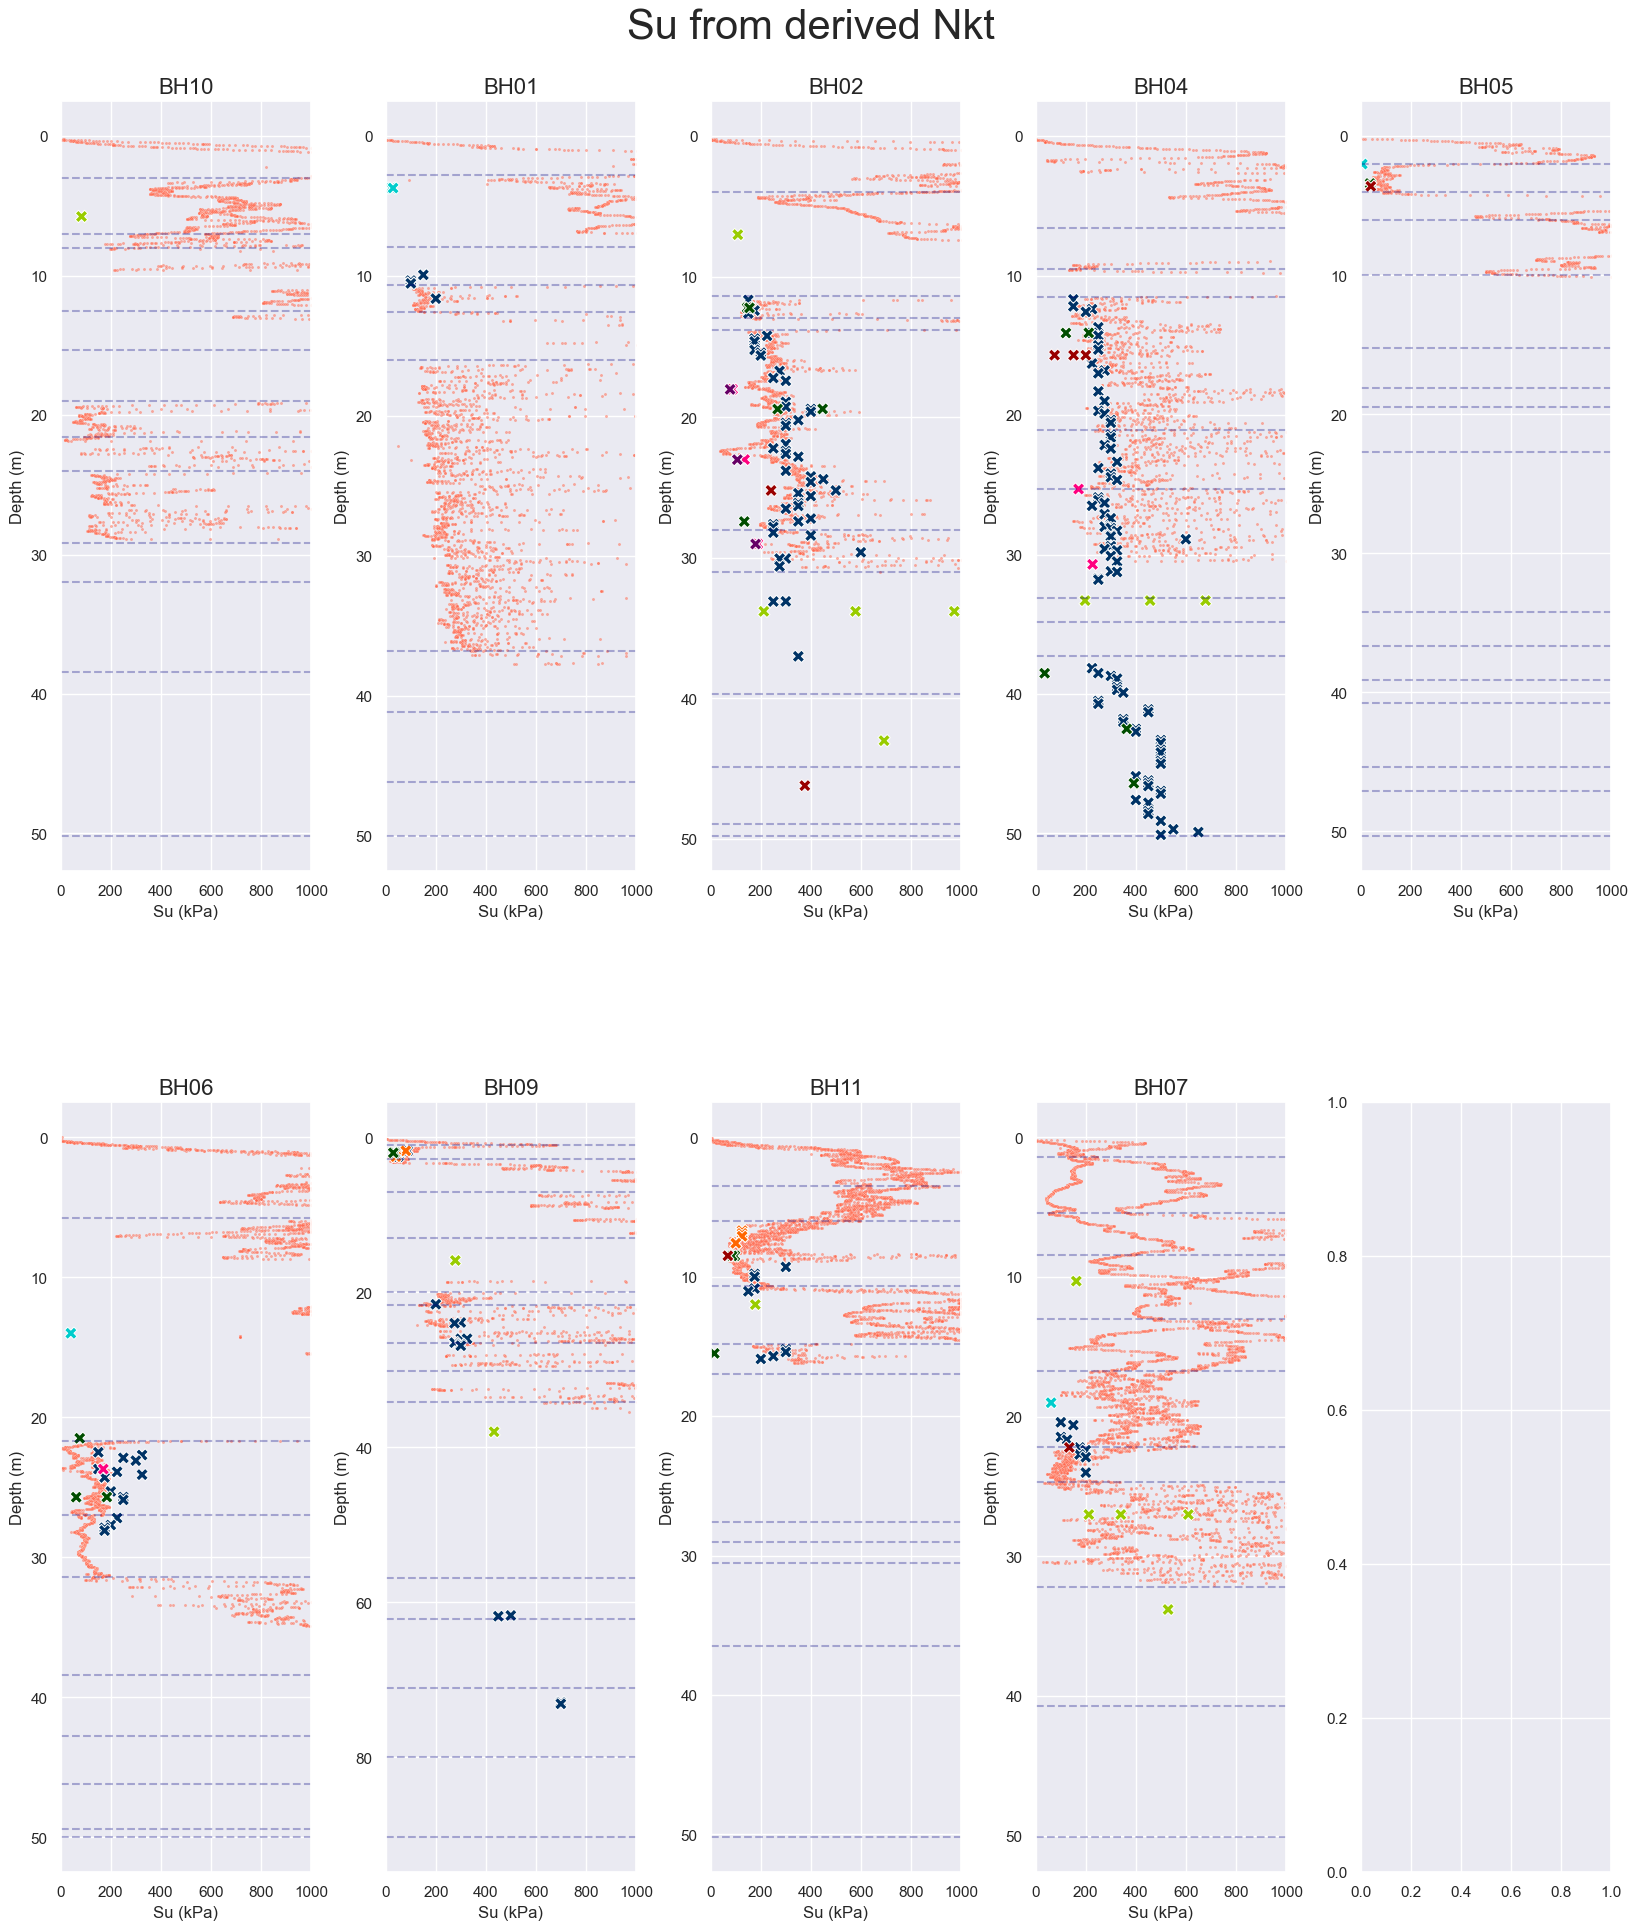

In [42]:
plot_df = cpt_df
xmin, xmax = 0, 1000
su_test_palette = {'LPEN': "#003366", 'TORV':"#ff6600", 'UU':"#004d00", 'CAUC':"#ff007f", 'CAUE':"#660066",
 'CID':"#99cc00", 'CIU':"#990000", 'DSS':"#00cccc"}
############################
borehole_list = plot_df["PointID"].unique()
bh = 0
fig, axes = plt.subplots(2, 5)
fig.suptitle(f"Su from derived Nkt", size=30, x=0.5, y=0.92)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
sns.set(rc={"figure.figsize":(20, 23)})
sns.set(font_scale=1) 
for row in range(2):
    for col in range(5):
        if bh >= len(borehole_list):
            pass
        else:
            filtered_df = plot_df[plot_df["PointID"] == borehole_list[bh]]
            fsu_df = su_df[su_df["PointID"] == borehole_list[bh]]
            ax = sns.scatterplot(data=filtered_df, x="Su (Nkt derived)", y="Depth (m)", alpha=0.5, ax=axes[row, col], color="tomato", s=5)
            ax = sns.scatterplot(data=fsu_df, x=parameter, y="Depth", hue="Test", marker="X", alpha=1, ax=axes[row, col], s=80,
                                palette=su_test_palette, legend=False)
            #ax = sns.scatterplot(data=fsu_df, x=parameter, y="Depth", hue="Nkt check", marker="X", alpha=1, ax=axes[row, col], s=80,
                                #palette=dict(Out="#9b59b6", In="#076928", Mid="#f20000"))
 
            # Plot geology
            bh_geo = geo_df[geo_df["PointID"] == borehole_list[bh]]
            for z in bh_geo["Depth"].to_list():
                    ax = sns.lineplot(x=[xmin, xmax], y=[z, z], ax=axes[row, col], alpha=0.3, color="navy", linestyle='dashed')
            ax.set_title(borehole_list[bh][-4:], size=16)
            ax.set_ylabel("Depth (m)")
            ax.set_xlabel("Su (kPa)")
            ax.invert_yaxis()
            ax.set_xlim(0, 1000)
            #ax.legend()
            bh += 1

In [33]:
su_df["Test"].unique()

array(['LPEN', 'TORV', 'UU', 'CAUC', 'CAUE', 'CID', 'CIU', 'DSS'],
      dtype=object)

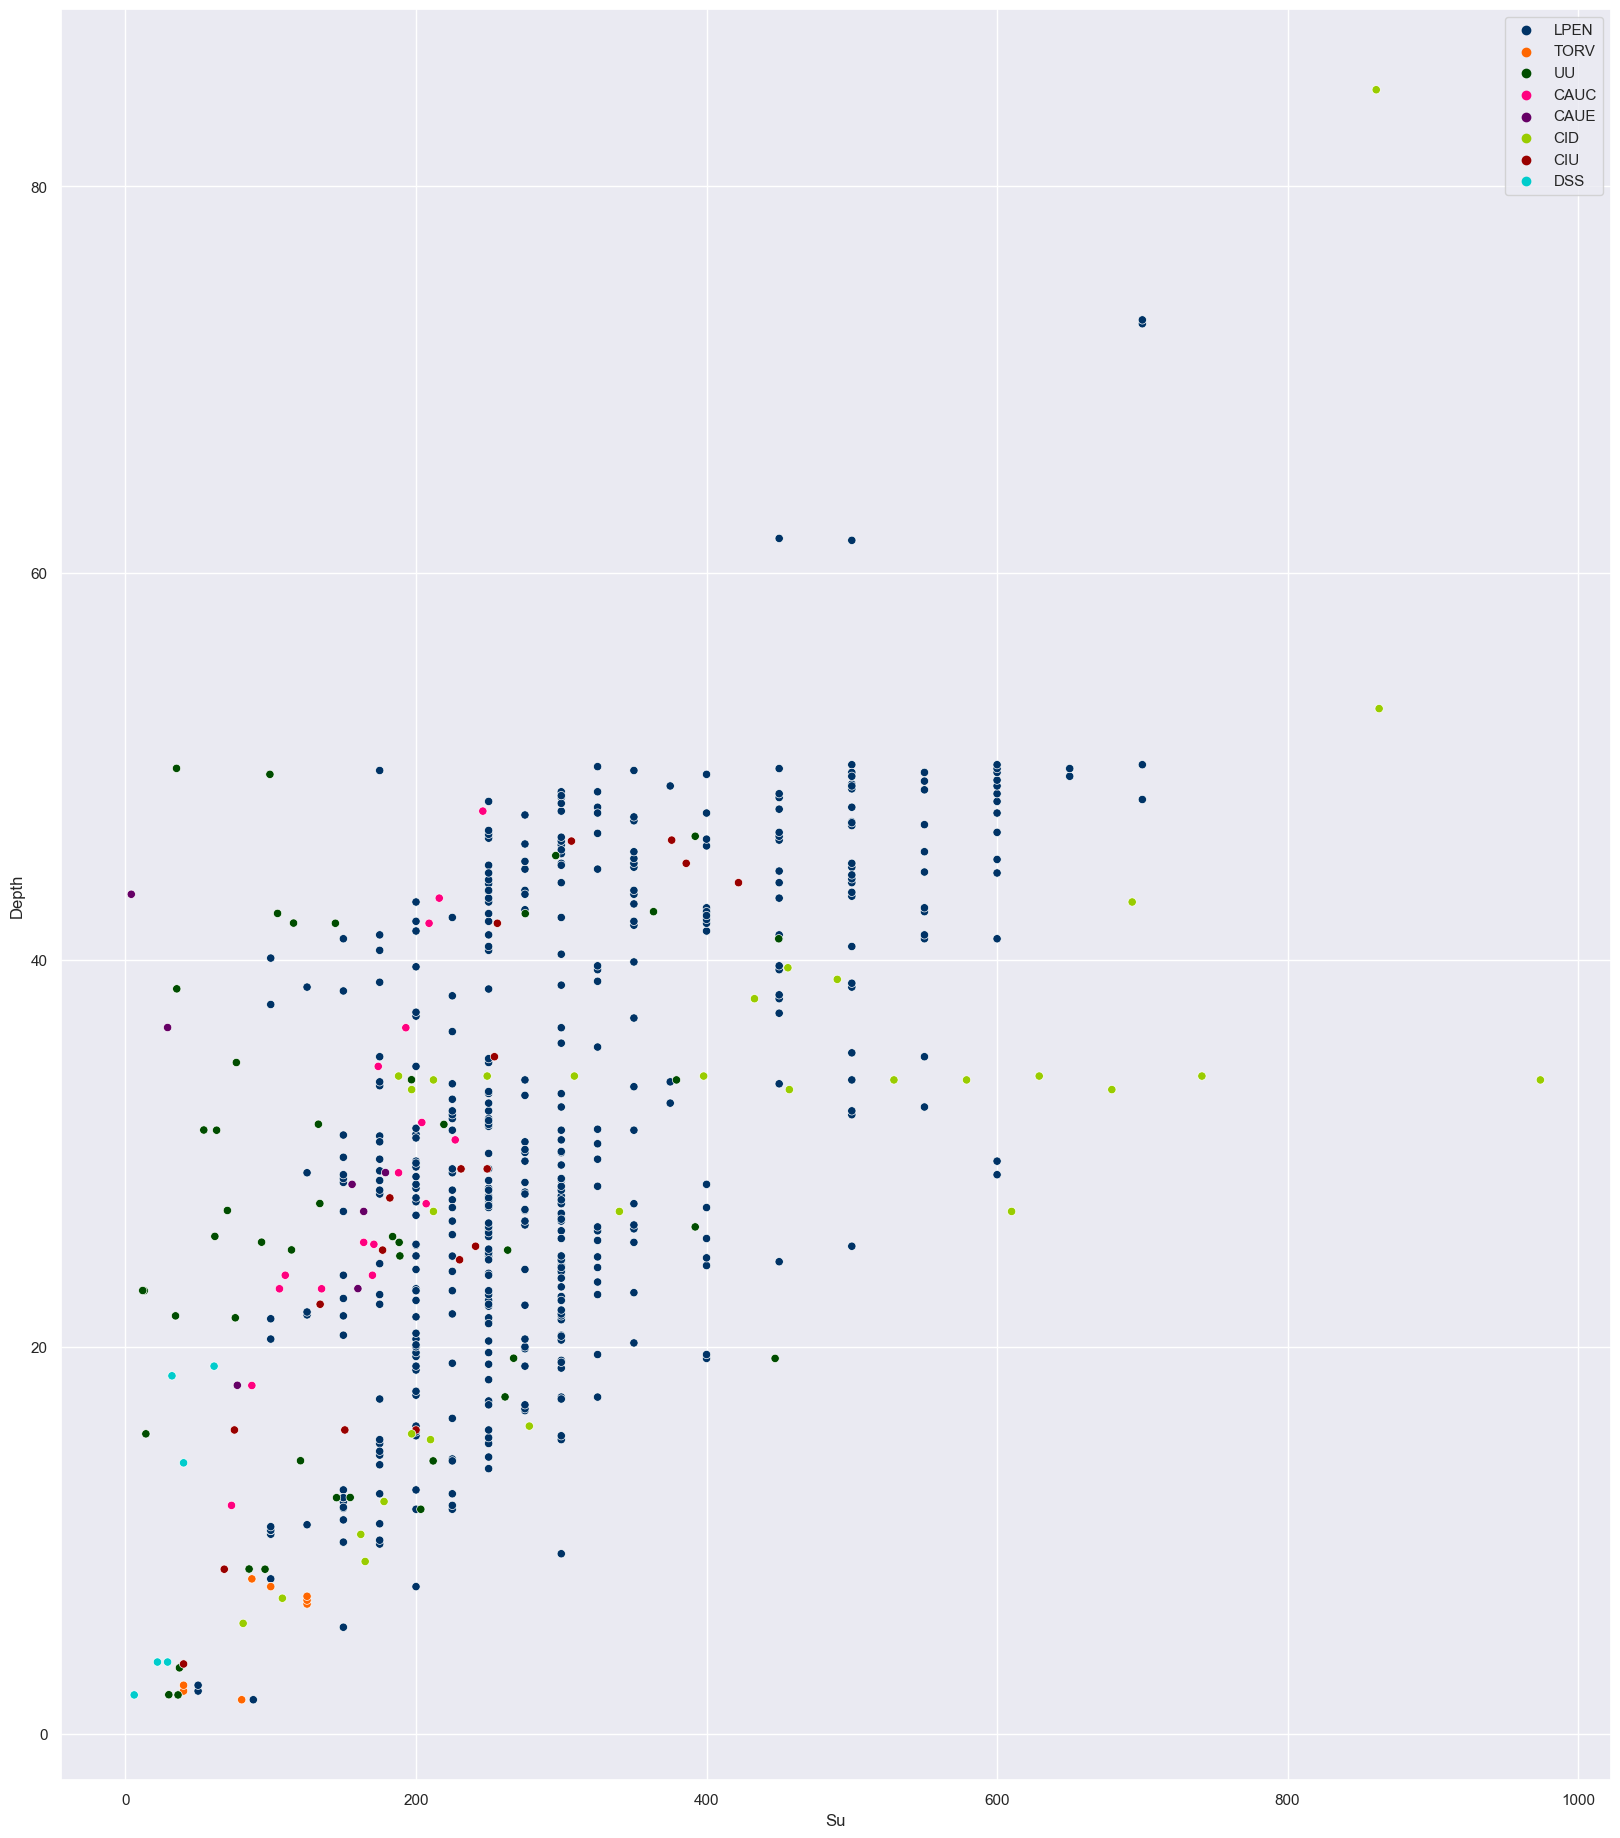

In [41]:
su_test_palette = {'LPEN': "#003366", 'TORV':"#ff6600", 'UU':"#004d00", 'CAUC':"#ff007f", 'CAUE':"#660066",
 'CID':"#99cc00", 'CIU':"#990000", 'DSS':"#00cccc"}
ax = sns.scatterplot(data=su_df, x="Su", y="Depth", hue="Test", palette=su_test_palette)
ax.legend()